# Install Data

In [1]:
!rm -rf /content/test_dataV1.zip
!rm -rf /content/test_dataV1
!gdown -q 1dRu7KlY3jyrdCzoQSpnjvzGdIKOxnU6G
!unzip -q /content/test_dataV1.zip


# Install Library

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from datetime import datetime
from glob import glob
import imageio
from tempfile import TemporaryDirectory
# cudnn.benchmark = True
plt.ion()   # interactive mode

# Preprocessing

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456,0.406],[0.229,0.224,0.225])
])

In [4]:
batch_size = 64
train_dataset = datasets.ImageFolder(
    '/content/test_dataV1/train',
    transform = train_transform
)
val_dataset = datasets.ImageFolder(
    '/content/test_dataV1/val',
    transform = test_transform
)
test_dataset = datasets.ImageFolder(
    '/content/test_dataV1/test',
    transform = test_transform
)

In [5]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle =True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size = batch_size,
    shuffle =False
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle =False
)

In [6]:
# Class torchvision.datasets.ImageFolder
if hasattr(train_dataset, 'classes'):
    print("Class labels:", train_dataset.classes)
else:
    print("Class labels not found.")

if hasattr(test_dataset, 'classes'):
    print("Class labels:", test_dataset.classes)
else:
    print("Class labels not found.")


Class labels: ['A1', 'A2', 'A3', 'F1', 'F2', 'F3', 'G1', 'G2', 'G3']
Class labels: ['A1', 'A2', 'A3', 'F1', 'F2', 'F3', 'G1', 'G2', 'G3']


In [7]:
model = models.mobilenet_v2(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 46.2MB/s]


## In ra kiến trức model mobilev2

In [8]:
# print(model)

In [9]:
# lớp phân loại của mobilenetv2
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [10]:
n_class = 9
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs,num_ftrs),
    nn.Dropout(0.3),
    nn.Linear(num_ftrs,num_ftrs),
    nn.Dropout(0.4),
    nn.Linear(num_ftrs,num_ftrs),
    nn.Dropout(0.7),
    nn.Linear(num_ftrs,n_class)
)

In [11]:
# lớp phân loại sau khi sửa và thêm các lớp cuối
model.classifier

Sequential(
  (0): Linear(in_features=1280, out_features=1280, bias=True)
  (1): Dropout(p=0.3, inplace=False)
  (2): Linear(in_features=1280, out_features=1280, bias=True)
  (3): Dropout(p=0.4, inplace=False)
  (4): Linear(in_features=1280, out_features=1280, bias=True)
  (5): Dropout(p=0.7, inplace=False)
  (6): Linear(in_features=1280, out_features=9, bias=True)
)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [13]:
# Loss and optimizer
criteration = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Tạo thư mục chứa weight

In [14]:
folder_path = "output"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f'Thư mục "{folder_path}" đã được tạo.')
else:
    print(f'Thư mục "{folder_path}" đã tồn tại.')


Thư mục "output" đã được tạo.


# Training

In [15]:
def batch_gd(model, criteration, optimizer, train_loader, test_loader, epoch):
  train_losses = np.zeros(epoch)
  train_accs = np.zeros(epoch)
  test_losses = np.zeros(epoch)
  test_accs = np.zeros(epoch)
  best_acc = 0.0
  best_model_params_path = os.path.join(folder_path, 'MobileNetV2_best.pt')
  last_model_params_path = os.path.join(folder_path, 'MobileNetV2_last.pt')
  for it in range(epoch):
    print(f"Epoch {it+1}/{epoch}")
    print('-' * 10)
    model.train()
    t0 = datetime.now()
    train_loss = []
    n_correct = 0
    n_total = 0
    train_acc = 0
    # Get train_acc and train_loss
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()
      #forward pass
      outputs = model(inputs)
      loss = criteration(outputs, targets)
      _, predictions = torch.max(outputs, 1)
      # acc
      n_correct += (predictions == targets).sum().item()
      n_total += targets.shape[0]
      # Backward
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
    train_loss = np.mean(train_loss)
    train_acc = n_correct/n_total

    # Save loss and test
    train_losses[it] = train_loss
    train_accs[it] = train_acc

    #Get test loss and test acc
    model.eval()
    test_loss = []
    n_correct = 0
    n_total = 0
    test_acc = 0.0
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criteration(outputs, targets)
      _, predictions = torch.max(outputs, 1)
      # acc
      n_correct += (predictions == targets).sum().item()
      n_total += targets.shape[0]
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)
    test_acc = n_correct/n_total
    # get best accuracy
    if best_acc < test_acc:
      best_acc = test_acc
      torch.save(model.state_dict(), best_model_params_path)
    # Save Loss
    test_losses[it] = test_loss
    test_accs[it] = test_acc

    dt = datetime.now() - t0
    print(f'Train Acc: {train_acc:.4f}, Loss: {train_loss:.4f} \nTest Acc: {test_acc:.4f},Loss:{test_loss:.4f} \nDuration {dt}\n')
    if it == epoch -1:
      print("\n----------------------\n")
      print(f"Best Accuracy: {best_acc:.4f}")
      torch.save(model.state_dict(), last_model_params_path)
  return train_losses, test_losses,train_accs,test_accs

In [16]:
epochs = 20
train_losses, val_losses, train_acc, val_acc = batch_gd(
    model,
    criteration,
    optimizer,
    train_loader,
    val_loader,
    epochs
)

Epoch 1/20
----------
Train Acc: 0.1154, Loss: 2.2102 
Test Acc: 0.1424,Loss:2.1688 
Duration 0:00:32.022922

Epoch 2/20
----------
Train Acc: 0.1384, Loss: 2.1621 
Test Acc: 0.1424,Loss:2.1376 
Duration 0:00:23.195102

Epoch 3/20
----------
Train Acc: 0.1519, Loss: 2.1320 
Test Acc: 0.1432,Loss:2.0905 
Duration 0:00:23.473862

Epoch 4/20
----------
Train Acc: 0.1543, Loss: 2.0791 
Test Acc: 0.1512,Loss:2.0530 
Duration 0:00:23.534549

Epoch 5/20
----------
Train Acc: 0.1870, Loss: 2.0095 
Test Acc: 0.1702,Loss:1.9754 
Duration 0:00:24.439011

Epoch 6/20
----------
Train Acc: 0.2617, Loss: 1.9123 
Test Acc: 0.2355,Loss:1.8394 
Duration 0:00:23.643826

Epoch 7/20
----------
Train Acc: 0.2418, Loss: 1.8092 
Test Acc: 0.2570,Loss:1.7082 
Duration 0:00:23.583577

Epoch 8/20
----------
Train Acc: 0.2506, Loss: 1.7044 
Test Acc: 0.2538,Loss:1.6438 
Duration 0:00:23.304468

Epoch 9/20
----------
Train Acc: 0.2880, Loss: 1.6358 
Test Acc: 0.2665,Loss:1.6054 
Duration 0:00:23.934230

Epoch 10/2

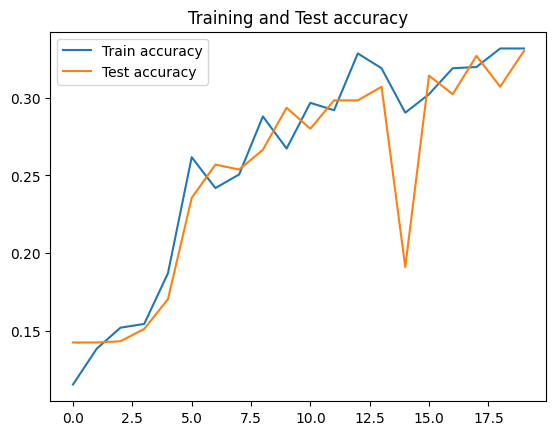

In [17]:
#plot train loss and test loss
plt.plot(train_acc, label="Train accuracy")
plt.plot(val_acc, label="Test accuracy")
plt.title("Training and Test accuracy")
plt.legend()
plt.show()

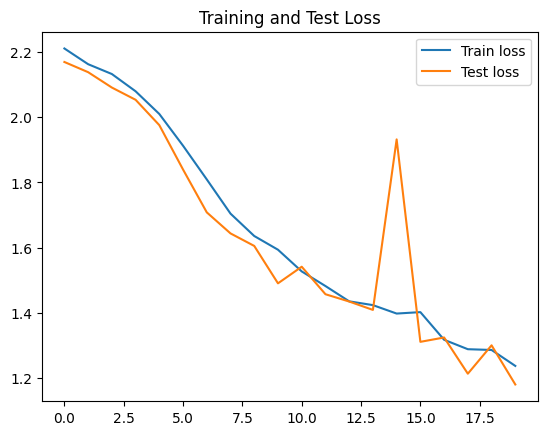

In [18]:
#plot train loss and test loss
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Test loss")
plt.title("Training and Test Loss")
plt.legend()
plt.show()

In [19]:

n_correct = 0
n_total = 0

for inputs, targets in test_loader:
  #move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs,1)

  # Update count
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct/n_total

In [20]:
test_acc

0.33015115354017505

In [21]:
#plot confusion matrix

from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, normalize = False,title = "confusion matrix",cmap = plt.cm.Blues):
  if normalize:
    cm = cm.astype("float")/cm.sum(axis=1)[:,np.newaxis]
    print("Normalize confusion matrix")
  else:
    print("Confusion maxtrix, without normalization")
  print(cm)

  plt.imshow(cm, interpolation = "nearest", cmap = cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks,classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max()/2

  for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,format(cm[i,j],fmt),horizontalalignment="center", color = 'white' if cm[i,j]> thresh else "black")

  plt.tight_layout()
  plt.ylabel("True label")
  plt.xlabel("Prediction")
  plt.show()


Confusion maxtrix, without normalization
[[127   1   7   1   0   0   1   0   0]
 [127   1   7   1   0   0   1   0   0]
 [127   1   7   1   0   0   1   0   0]
 [  0   0   1  99   0   3   0   0   0]
 [  0   0   1  99   0   3   0   0   0]
 [  0   0   1  99   0   3   0   0   0]
 [  1   0   0   0   0   0   5 172   1]
 [  1   0   0   0   0   0   5 172   1]
 [  1   0   0   0   0   0   5 172   1]]


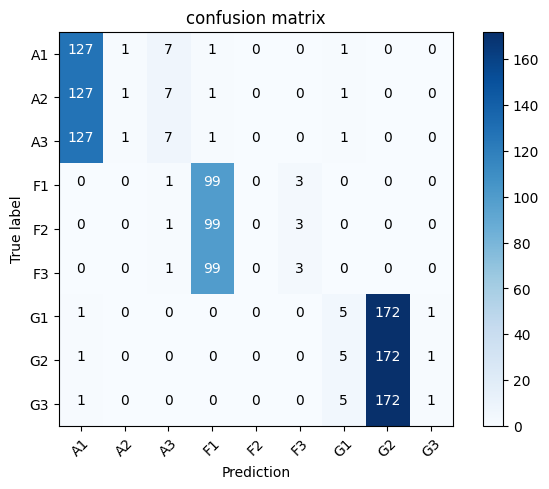

In [22]:
# get all prediction in an array and plot confusion matrix
x_test = test_dataset.imgs
y_test = test_dataset.targets
p_test = np.array([])

for inputs, targets in test_loader:
  inputs = inputs.to(device)
  outputs = model(inputs)
  _, predictions = torch.max(outputs, 1)
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))
cm = confusion_matrix(y_test, p_test)
x = list(train_dataset.classes)
plot_confusion_matrix(cm, x)

# Load best model

In [23]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.to(device)

In [24]:
model.load_state_dict(torch.load('/content/output/MobileNetV2_best.pt'))
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [25]:
n_correct = 0
n_total = 0

for inputs, targets in test_loader:
  #move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs,1)

  # Update count
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc_best = n_correct/n_total
print(test_acc_best)

0.33015115354017505


In [26]:

from sklearn.metrics import classification_report

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    report = classification_report(all_labels, all_preds, target_names=test_dataset.classes, digits = 4)
    return report

# Sử dụng hàm evaluate_model để đánh giá mô hình trên tập kiểm thử
test_report = evaluate_model(model, test_loader, device)#val, test
print(test_report)

              precision    recall  f1-score   support

          A1     0.3307    0.9270    0.4875       137
          A2     0.3333    0.0073    0.0143       137
          A3     0.2917    0.0511    0.0870       137
          F1     0.3300    0.9612    0.4913       103
          F2     0.0000    0.0000    0.0000       103
          F3     0.3333    0.0291    0.0536       103
          G1     0.2778    0.0279    0.0508       179
          G2     0.3333    0.9609    0.4950       179
          G3     0.3333    0.0056    0.0110       179

    accuracy                         0.3302      1257
   macro avg     0.2848    0.3300    0.1878      1257
weighted avg     0.2930    0.3302    0.1881      1257



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion maxtrix, without normalization
[[127   1   7   1   0   0   1   0   0]
 [127   1   7   1   0   0   1   0   0]
 [127   1   7   1   0   0   1   0   0]
 [  0   0   1  99   0   3   0   0   0]
 [  0   0   1  99   0   3   0   0   0]
 [  0   0   1  99   0   3   0   0   0]
 [  1   0   0   0   0   0   5 172   1]
 [  1   0   0   0   0   0   5 172   1]
 [  1   0   0   0   0   0   5 172   1]]


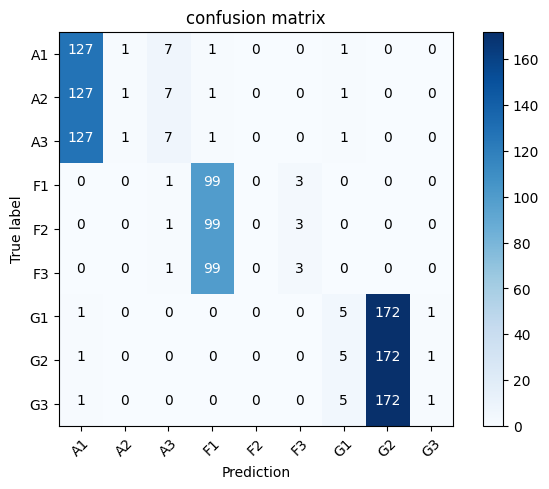

In [27]:
# get all prediction in an array and plot confusion matrix
x_test = test_dataset.imgs
y_test = test_dataset.targets
p_test = np.array([])

for inputs, targets in test_loader:
  inputs = inputs.to(device)
  outputs = model(inputs)
  _, predictions = torch.max(outputs, 1)
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))
cm = confusion_matrix(y_test, p_test)
x = list(train_dataset.classes)
plot_confusion_matrix(cm, x)